# Visualize training of Beta VAE on dynamic circle/Gaussian data


### training parameters
- Input: sequences of translating circles on Gaussian-blob background (32x32)

- Number of latents: 4

- batch size: 64

- 50K training samples
- RMSprop w lr = 1e-04

- loss: DKL + reconstruction loss + gamma*prediction loss


Beta VAE:
- six different normalized beta Values (spacing of sampling roughly corresponding to Higgins 2017 y-axis):


``` normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e) ```

``` gamma_values = np.logspace(-4, 4, 5, base=10) ```


In [1]:
import torch
import pickle
from models import dynamicVAE32, beta_from_normalized_beta

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesbT import dSpriteBackgroundDatasetTime

from sklearn.cluster.bicluster import SpectralBiclustering

In [2]:
n_latent = 4

normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)
gamma_values = np.logspace(-4, 4, 5, base=10)
gamma_values = np.insert(gamma_values,0,0)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.4f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])
print('gammas: ', gamma_values)

['betanorm = 0.0010 / beta = 0.1']
['betanorm = 0.0055 / beta = 0.6']
['betanorm = 0.0302 / beta = 3.1']
['betanorm = 0.1657 / beta = 17.0']
['betanorm = 0.9103 / beta = 93.2']
['betanorm = 5.0000 / beta = 512.0']
gammas:  [0.e+00 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04]


In [3]:
vae = list()
training_stats = list()

nb = normalized_beta_values.shape[0]
ng = gamma_values.shape[0]

isTrained = [False]*(nb*ng)

for jj,gamma in enumerate(gamma_values):
    for ii,beta_norm in enumerate(normalized_beta_values):

        # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
        beta_norm_str = '%0.4f' % (beta_norm)
        while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
            beta_norm_str = beta_norm_str[:-1]
#         gamma_str = '%0.4f' % (gamma)

        trainedpath = 'checkpoints/dynamicvae32_nlatent=%s_betanorm=%s_gamma=%s_dsprites_circle_last' % (n_latent,beta_norm_str,gamma)
        trainstatspath = 'trainstats/dynamicvae32_nlatent=%s_betanorm=%s_gamma=%s_dsprites_circle.pkl' % (n_latent,beta_norm_str,gamma)

        vae.append(dynamicVAE32(n_latent = n_latent))
        training_stats.append([])
#         try:
        checkpoint = torch.load(trainedpath)
        vae[nb*jj+ii].load_state_dict(checkpoint['model_states']['net'])
        isTrained[nb*jj+ii] = True
#         except:
#             print('checkpoint not found: %s' % trainedpath)
            
        try:
            training_stats[nb*jj+ii] = pickle.load(open(trainstatspath, 'rb'))
            lastone=nb*jj+ii
        except:
            print('trainstats not found: %s' % trainstatspath)

In [4]:
vae[0].alpha

1.0

### plot training loss

Four different plots:

- loss = recon_loss + beta * kl_div + gamma*pred_loss
- recon_loss
- kl_div
- pred_loss

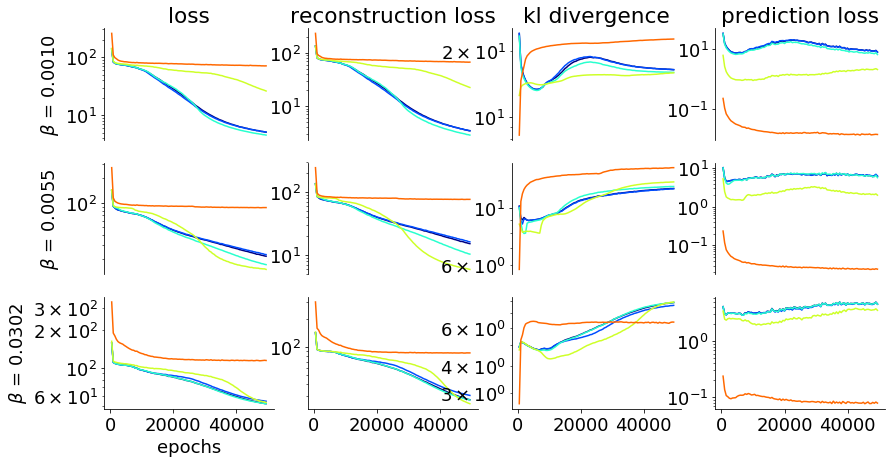

In [5]:
show_until_nth_batch = 200000
idx_lim = np.max(np.where(np.array(training_stats[lastone]['iter']) < show_until_nth_batch))

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(nb-3,4,sharey=False,sharex=True, figsize=(14,7))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(gamma_values)))
for jj,gam in enumerate(gamma_values[:-1]):
    for ii in range(0,3):#enumerate(normalized_beta_values):
        if training_stats[nb*jj+ii]:
            logged_steps = training_stats[nb*jj+ii]['iter'][:idx_lim]
            recon_loss = np.array(training_stats[nb*jj+ii]['recon_loss'][:idx_lim])
            total_kld = np.array(training_stats[nb*jj+ii]['total_kld'][:idx_lim])
            pred_loss = np.array(training_stats[nb*jj+ii]['pred_loss'][:idx_lim])

            ax[4*ii+0].plot(logged_steps, recon_loss+ beta[ii] * total_kld + gam*pred_loss, color=col[jj])
            ax[4*ii+1].plot(logged_steps, recon_loss, color=col[jj])
            ax[4*ii+2].plot(logged_steps, total_kld, color=col[jj])
            ax[4*ii+3].plot(logged_steps, pred_loss, color=col[jj])

            _ = [x.set(yscale='log') for x in ax]

#             if jj<1:
#                 ax[2].legend(['betanorm = %0.3f / beta = %0.1f' % (x,y) for x,y in zip(normalized_beta_values,beta)], loc=1)
            ax[4*ii+0].set(ylabel=(r'$\beta$ = %0.4f' % normalized_beta_values[ii]))

ax[0].set(title='loss')
ax[1].set(title='reconstruction loss')
ax[2].set(title='kl divergence')
ax[3].set(title='prediction loss')
ax[-4].set(xlabel='epochs')
for aa,_ in enumerate(ax):
    ax[aa].spines['top'].set_visible(False)
    ax[aa].spines['right'].set_visible(False)
    if aa<8:
        ax[aa].spines['bottom'].set_visible(False)
        ax[aa].tick_params(axis='x',which='both',bottom=False)

plt.savefig("pred_bVAE_training.pdf", dpi=300)

beta clearly modulates the trade-off between reconstruction and kl-divergence (as expected)


#### plotting reconstruction loss and kl-divergence + prediction loss for each beta value separately

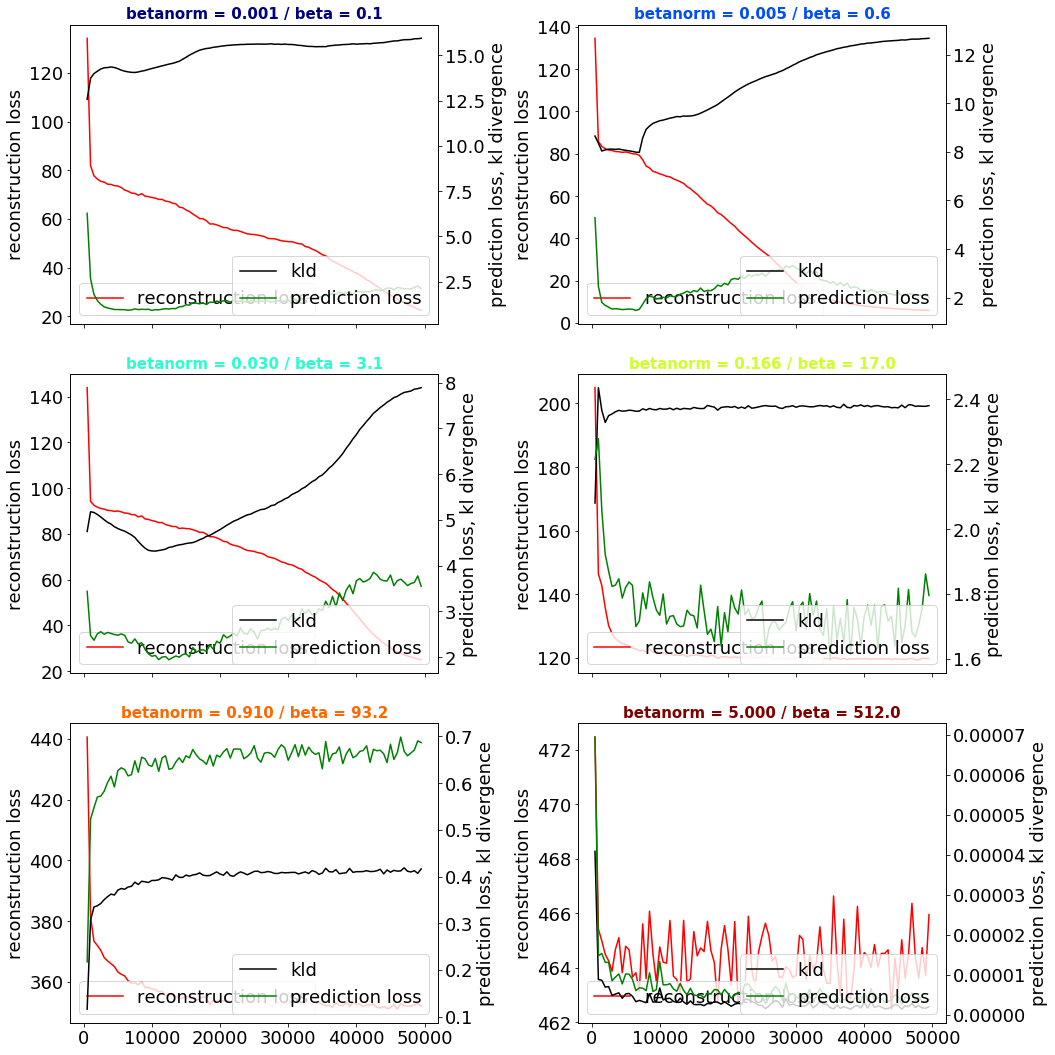

In [6]:
jj=3 # gamma = 1
idx_lim = np.max(np.where(np.array(training_stats[nb*jj]['iter']) < show_until_nth_batch))

fig, ax = plt.subplots(3,2,sharey=False,sharex=True, figsize=(15,15))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
ax2 = list()
for ii,_ in enumerate(normalized_beta_values):
    logged_steps = training_stats[nb*jj+ii]['iter'][:idx_lim]
    recon_loss = np.array(training_stats[nb*jj+ii]['recon_loss'][:idx_lim])
    total_kld = np.array(training_stats[nb*jj+ii]['total_kld'][:idx_lim])
    pred_loss = np.array(training_stats[nb*jj+ii]['pred_loss'][:idx_lim])
    
    ax[ii].plot(logged_steps, recon_loss, color='r', label='reconstruction loss')
    ax2.append(ax[ii].twinx())
    ax2[ii].plot(logged_steps, total_kld, color='k', label='kld')
    
    ax2[ii].plot(logged_steps, pred_loss, color='g', label='prediction loss')
    
    ##ax[0].set(ylabel='loss')
    #ax[1].set(ylabel='reconstruction loss')    
    ax[ii].set(ylabel='reconstruction loss')
    ax2[ii].set(ylabel='prediction loss, kl divergence')
    plt.title('betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii]), color=col[ii], 
              fontweight='bold', fontsize = 15)
    
    ax[ii].legend(loc=3)
    ax2[ii].legend(loc=4)
    
fig.tight_layout()

prediction loss tends to track KL-divergence

## load some data and plot reconstructions


In [5]:
ds = dSpriteBackgroundDatasetTime(transform=transforms.Resize(32),shapetype = 'circle')

In [6]:
isTrained

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


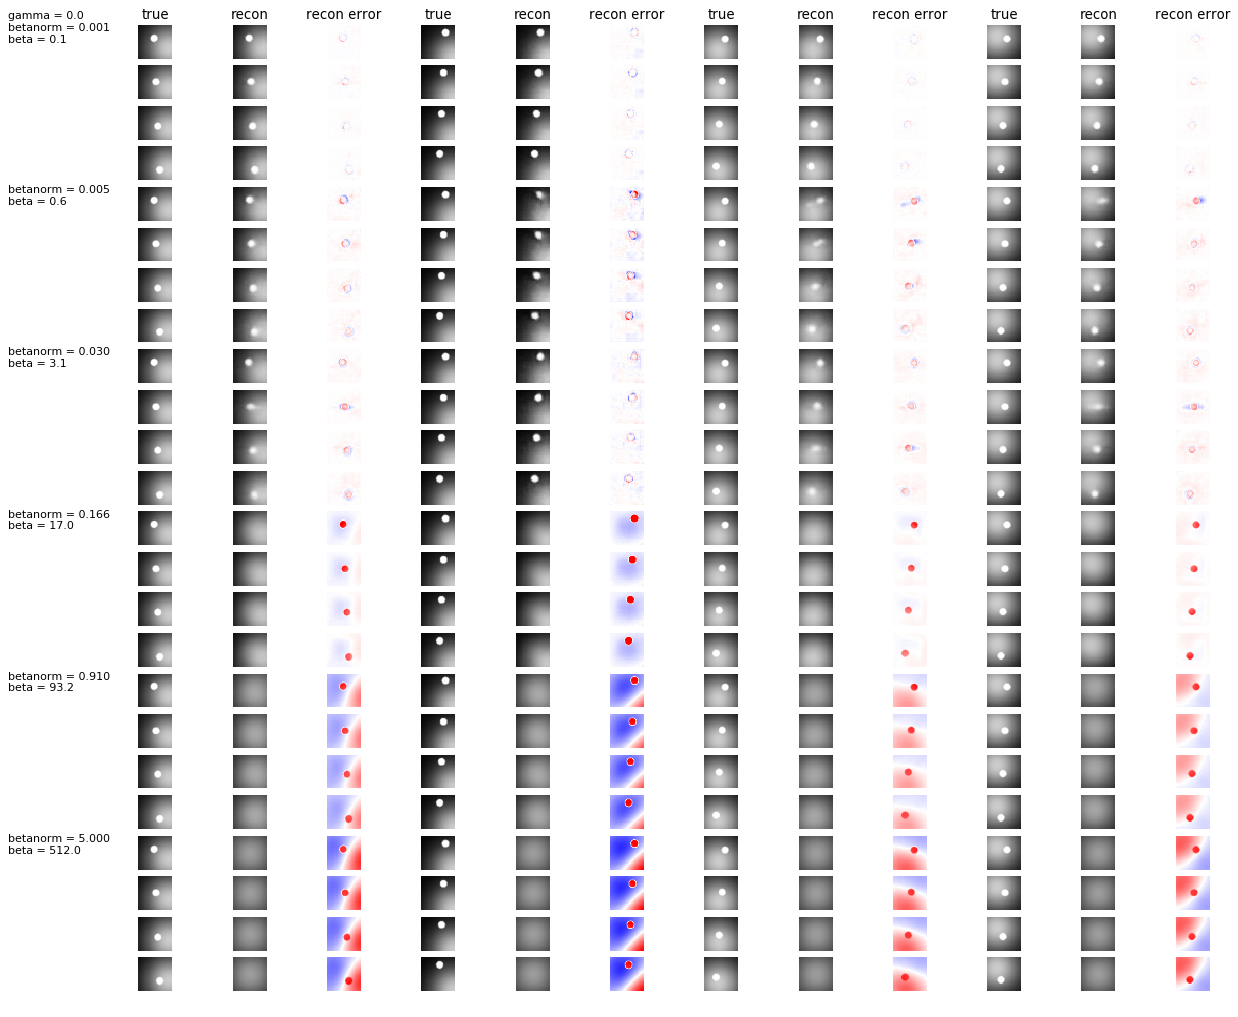

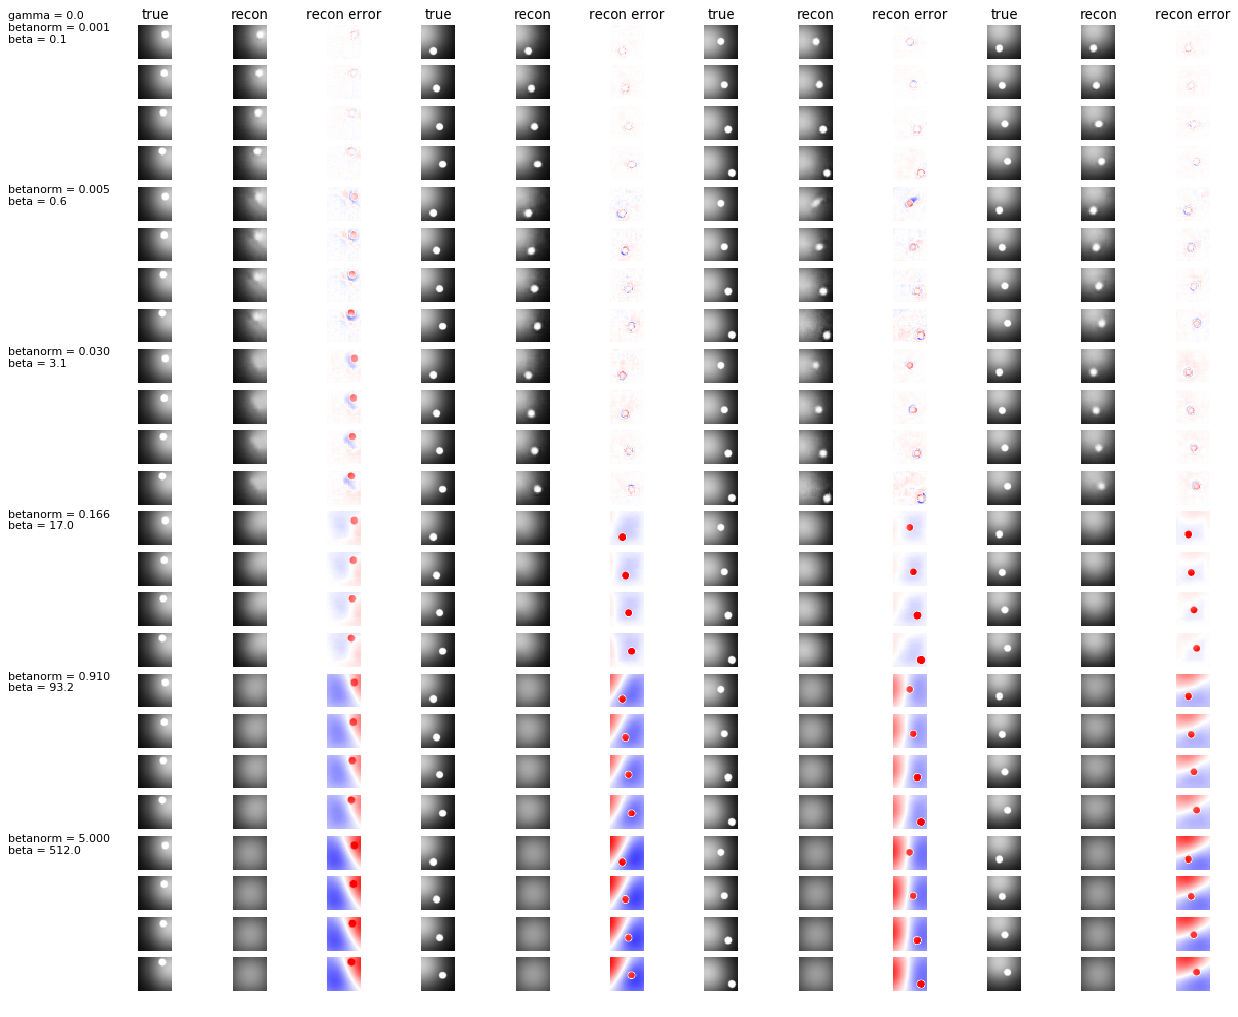

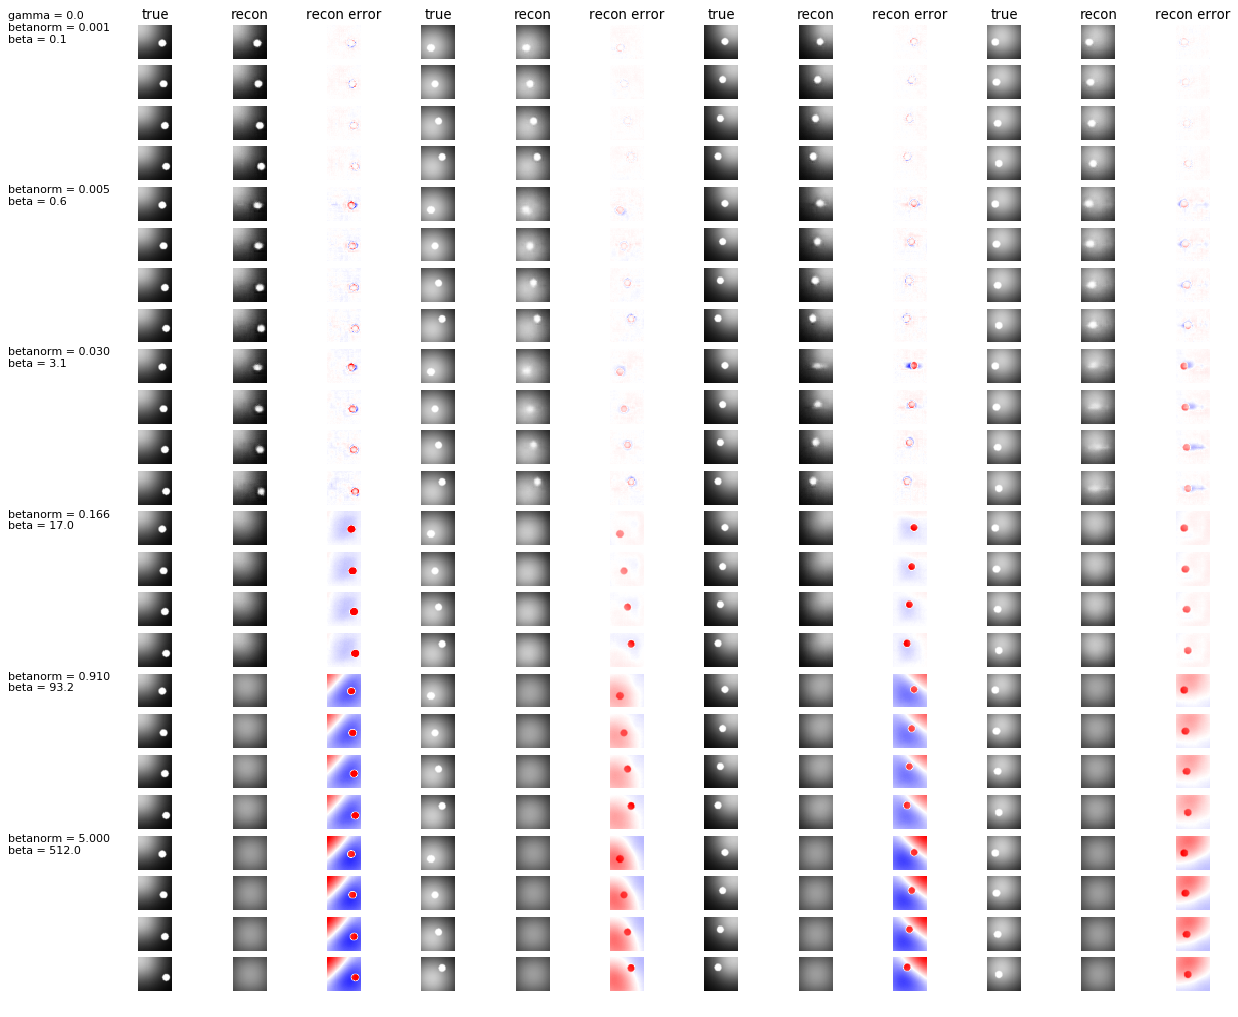

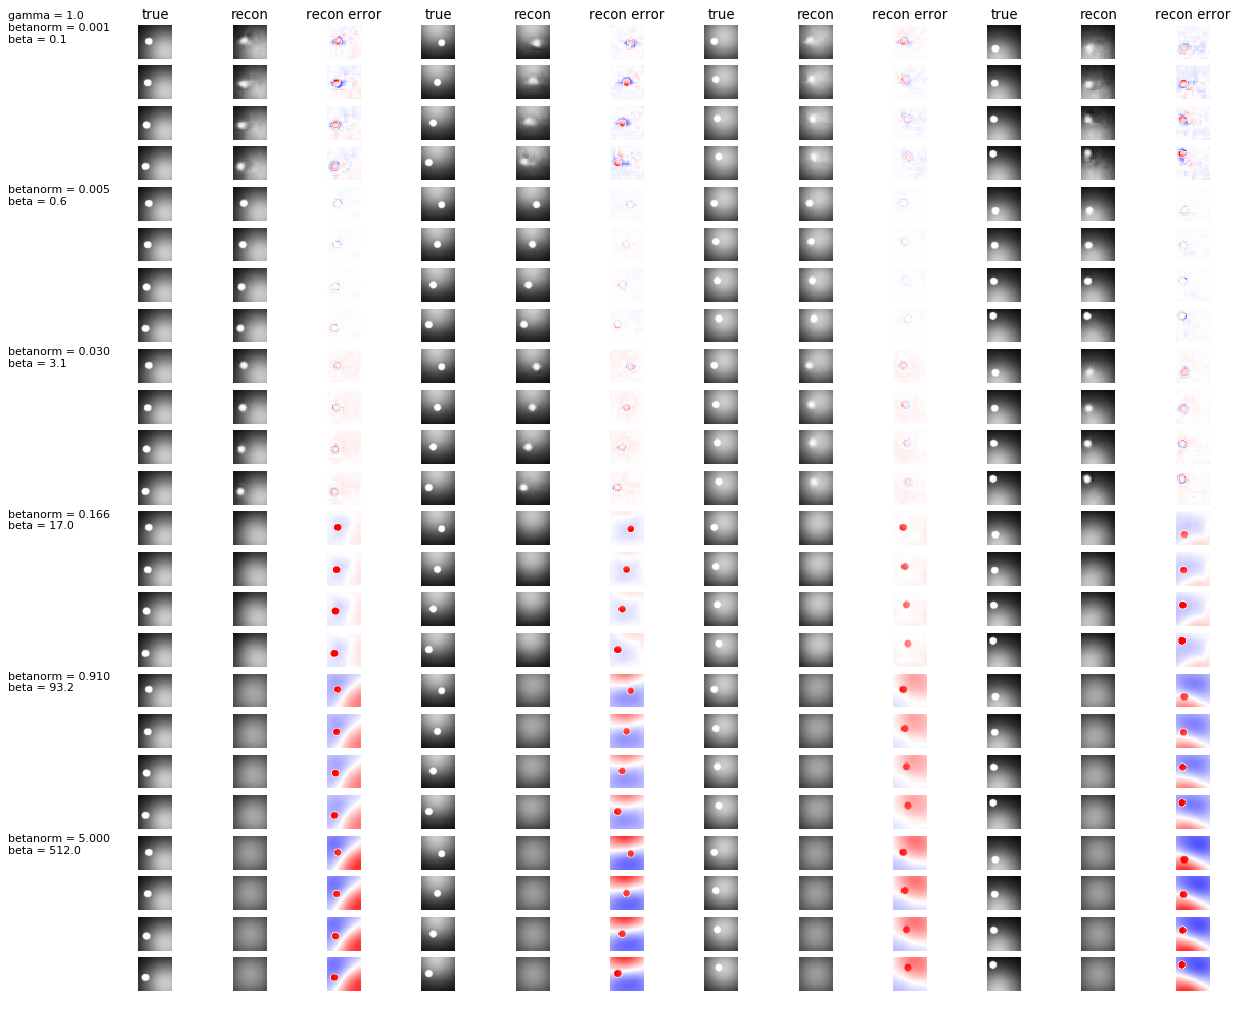

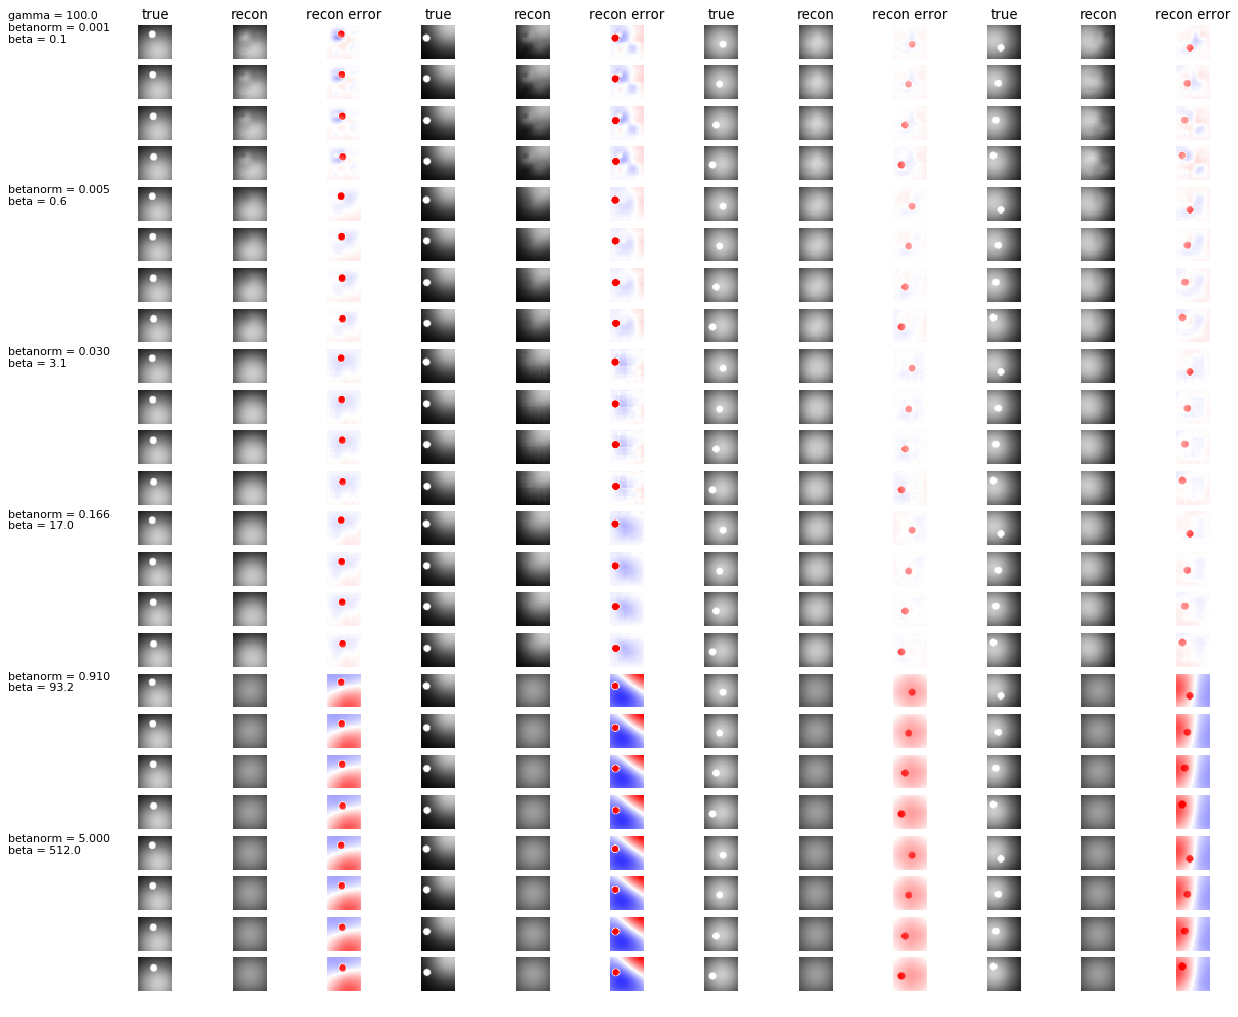

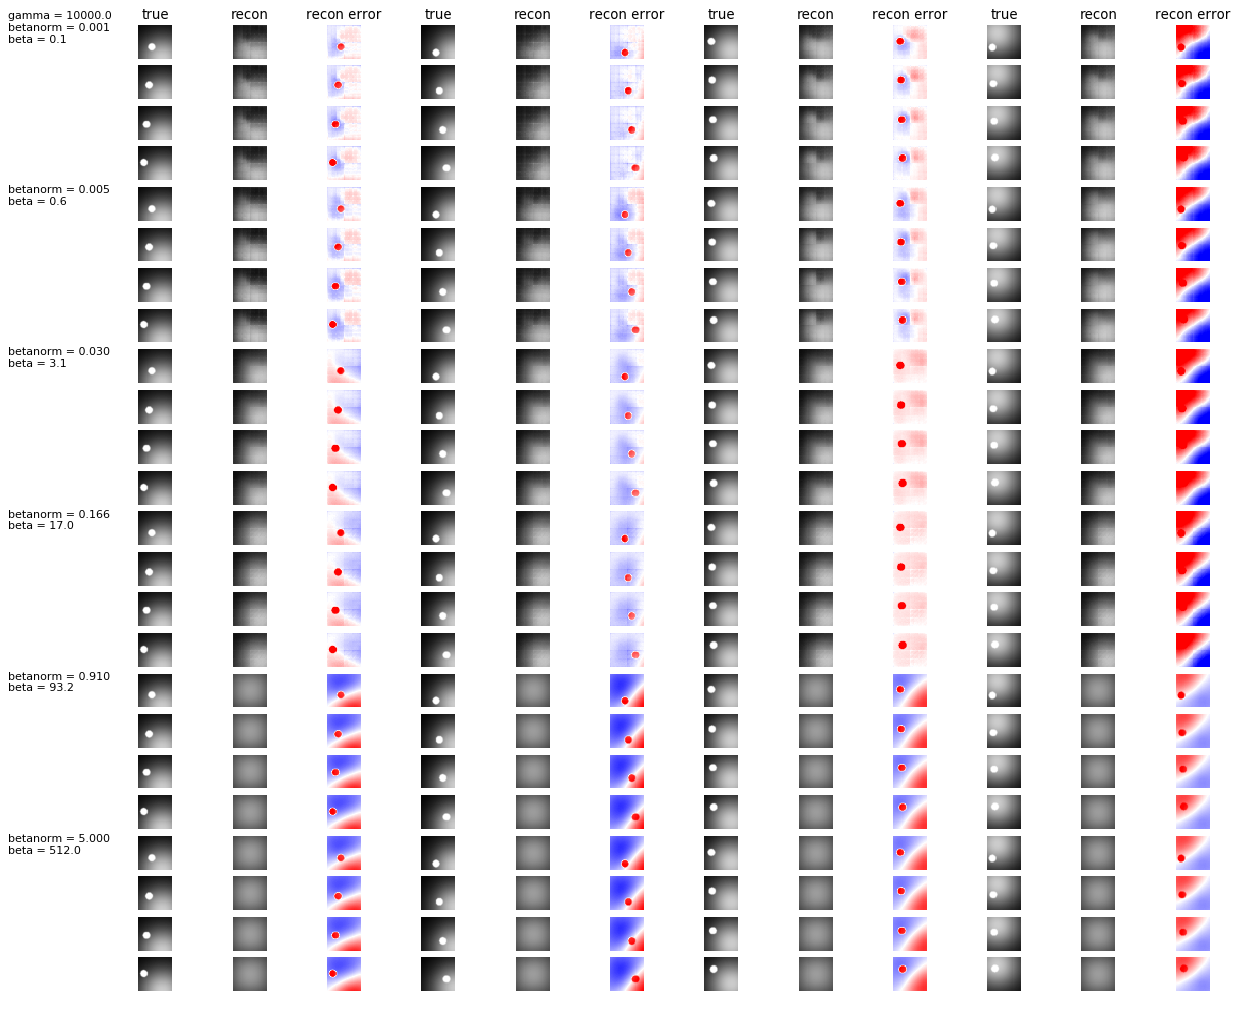

In [9]:
for gg,gam in enumerate(gamma_values): # loop across rows (different gamma values)

    if any(isTrained[(nb*gg+0):(nb*gg+nb)]):
        fig, ax = plt.subplots(nb*4,12,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        ax = ax.flatten()
        m = .5
        img_idx = np.random.randint(1000, size=4)

        for jj,_ in enumerate(normalized_beta_values): # loop across rows (different beta values)
            if isTrained[nb*gg+jj]:
                for ii in range(4): # loop across different samples

                    x,label = ds[img_idx[ii]]
                    x = x[np.newaxis, :, :]

                    mu, logvar = vae[nb*gg+jj].encode(x.float())
                    recon = vae[nb*gg+jj].decode(mu).detach()
                    diff = x - recon

                    for ff in range(1,5):
                        axnum = jj*12*4+(ff-1)*12+ii*3
                        plt.set_cmap('gray')
                        ax[axnum+0].imshow(x[:,ff*2,:,:,:].squeeze(), vmin=0, vmax=1)
                        ax[axnum+0].axis('off')

                        ax[axnum+1].imshow(recon[:,ff*2,:,:,:].squeeze(), vmin=0, vmax=1)
                        ax[axnum+1].axis('off')

                        plt.set_cmap('bwr')
                        img = ax[axnum+2].imshow(diff[:,ff*2,:,:,:].numpy().squeeze(), vmin=-m, vmax=m)
                        ax[axnum+2].axis('off')

                pos = ax[jj*12*4].get_position()
                if jj==0:
                    fig.text(.05, pos.y0 + pos.height/2, 'gamma = %0.1f\nbetanorm = %0.3f\nbeta = %0.1f' % (gam,normalized_beta_values[jj],beta[jj]))
                else:
                    fig.text(.05, pos.y0 + pos.height/2, 'betanorm = %0.3f\nbeta = %0.1f' % (normalized_beta_values[jj],beta[jj]))

        for ii in range(4):
            ax[ii*3+0].set(title='true')
            ax[ii*3+1].set(title='recon')
            ax[ii*3+2].set(title='recon error')
    

Each row displays the true/reconstructed/error for four samples with one beta.

- Interestingly, with increased beta, the circle object gets lost / is not captured by the VAE any more. 

- At very high beta values, the gaussian background blob is always reconstructed at the same (central) location. This is the case, when q(z|x) is almost equal to p(z), hence indepndent of x. The best "reconstruction" (to minimize reconstruction loss) is the mean image. -> probably, what we see in the high-beta reconstruction case is therefore not a central Gaussian but the average of all circle positions. As circles are constrained to not touch the image borders, this mean image looks like a centered Gaussian.

#### PLOT RECONSTRUCTION ERROR, PREDICTION ERROR

In [7]:
from models import prediction_loss,reconstruction_loss,kl_divergence,loss_function

In [8]:
nsamples = 100
pred_loss = np.zeros(shape=(ng,nb,nsamples),dtype=float)
recon_loss = np.zeros(shape=(ng,nb,nsamples),dtype=float)
kl_div = np.zeros(shape=(ng,nb,nsamples),dtype=float)
total_loss = np.zeros(shape=(ng,nb,nsamples),dtype=float)

for ii in range(nsamples): # loop across different samples
    x,_ = ds[ii]
    x = x[np.newaxis, :, :]

    for gg in range(ng):
        for jj in range(nb):
            recon,mu,logvar,mu_pred = vae[nb*gg+jj].forward(x.float())

            pred_loss[gg,jj,ii] = prediction_loss(mu,mu_pred)
            recon_loss[gg,jj,ii] = reconstruction_loss(x,recon)
            _,_,kl_div[gg,jj,ii] = kl_divergence(mu,logvar)
            total_loss[gg,jj,ii] = loss_function(recon_loss[gg,jj,ii],kl_div[gg,jj,ii],pred_loss[gg,jj,ii],
                                                 normalized_beta_values[jj],gamma_values[gg])
    

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


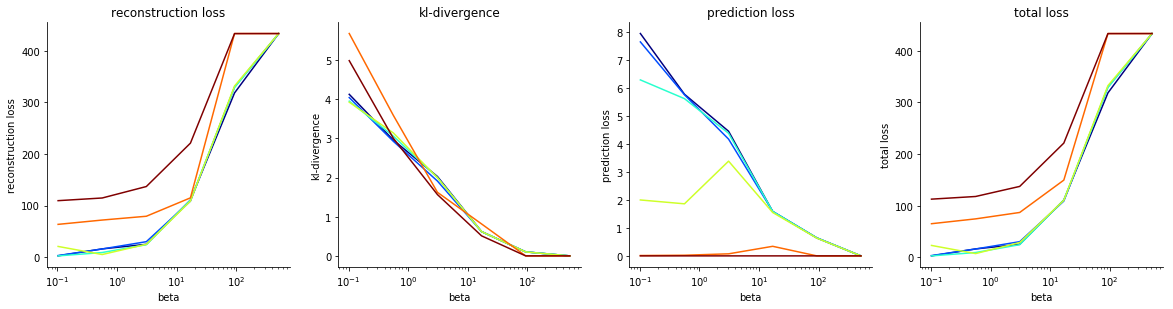

In [9]:
plt.rcParams.update({'font.size': 18})
col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
fig, ax = plt.subplots(1,4,figsize=(20,4.5))

ax[0] = plt.subplot(1,4,1)
plt.gca().set_prop_cycle(color=col)
plt.plot(normalized_beta_values,recon_loss.mean(2).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('reconstruction loss')
plt.title('reconstruction loss')

ax[1] = plt.subplot(1,4,2)
plt.gca().set_prop_cycle(color=col)
plt.plot(normalized_beta_values,kl_div.mean(2).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('kl-divergence')
plt.title('kl-divergence')

ax[2] = plt.subplot(1,4,3)
plt.gca().set_prop_cycle(color=col)
plt.plot(normalized_beta_values,pred_loss.mean(2).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('prediction loss')
plt.title('prediction loss')

ax[3] = plt.subplot(1,4,4)
plt.gca().set_prop_cycle(color=col)
plt.plot(normalized_beta_values,total_loss.mean(2).T)
# plt.colorbar()
# plt.set_cmap('gray_r')
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('total loss')
plt.title('total loss')

for aa,_ in enumerate(ax):
    ax[aa].spines['top'].set_visible(False)
    ax[aa].spines['right'].set_visible(False)
#     if aa<8:
#         ax[aa].spines['bottom'].set_visible(False)
#         ax[aa].tick_params(axis='x',which='both',bottom=False)

plt.savefig("pred_bVAE_loss_comparison.pdf", dpi=300)

In [10]:
from analyses.analyses import *

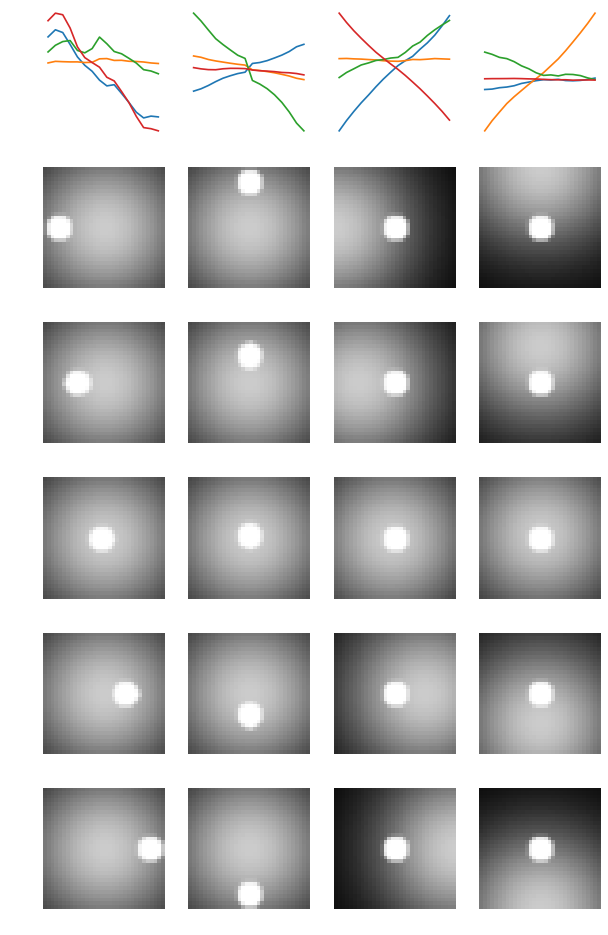

In [11]:
# %pdb on
yhat = torch.Tensor(nb*ng,n_latent,16,n_latent)
for gg in range(ng):
    for jj in range(nb):
        yhat[nb*gg+jj,:,:,:], x_sweep = sweepCircleLatents(vae[nb*gg+jj])#,latents=np.linspace(0,1,10))
_ = plotCircleSweep(yhat[:nb,:,:,:], x_sweep)

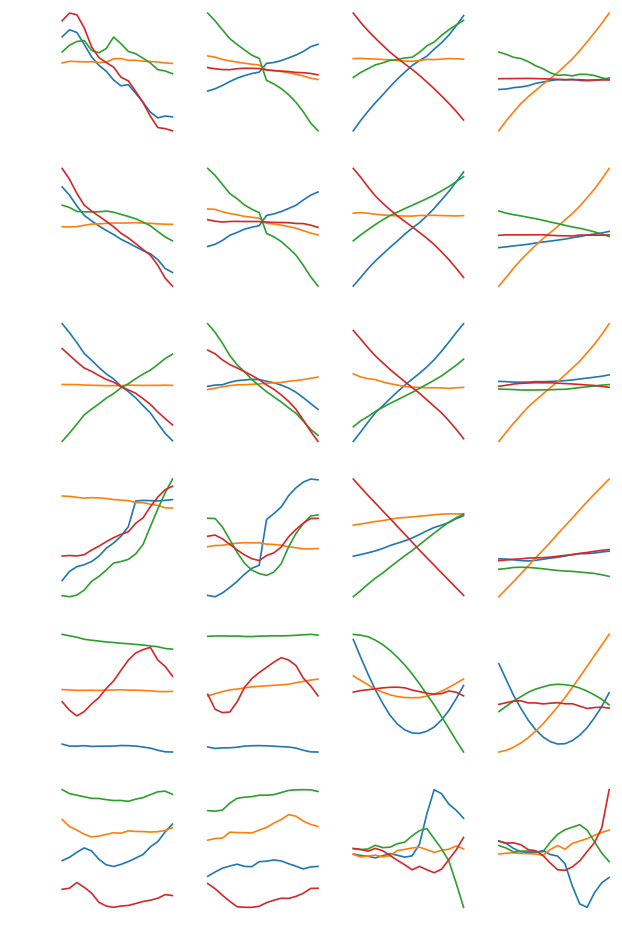

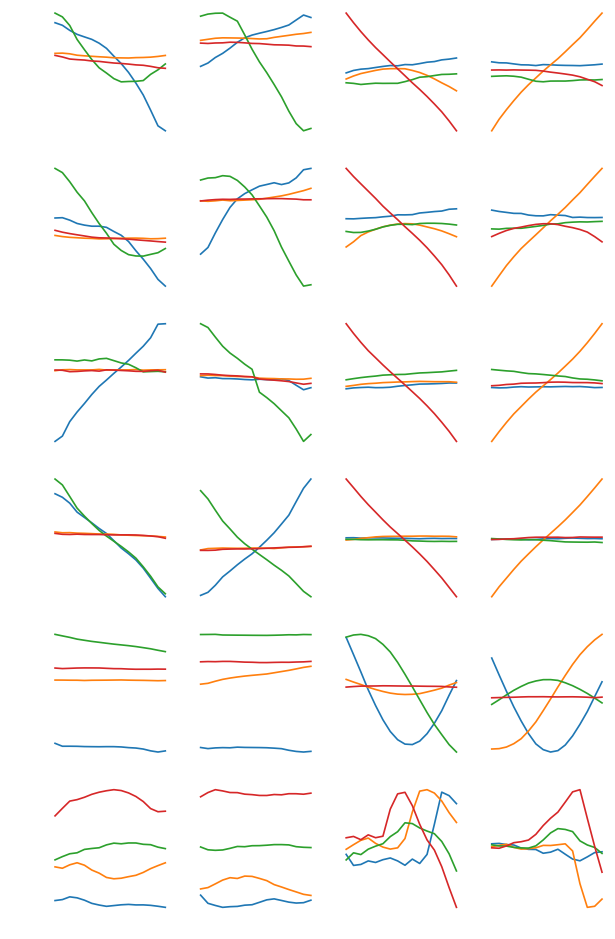

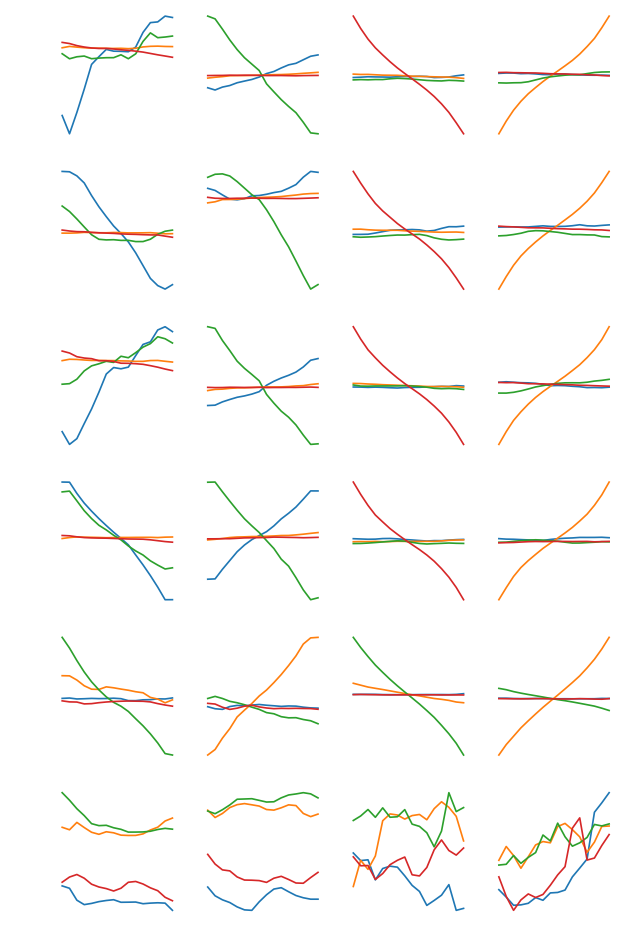

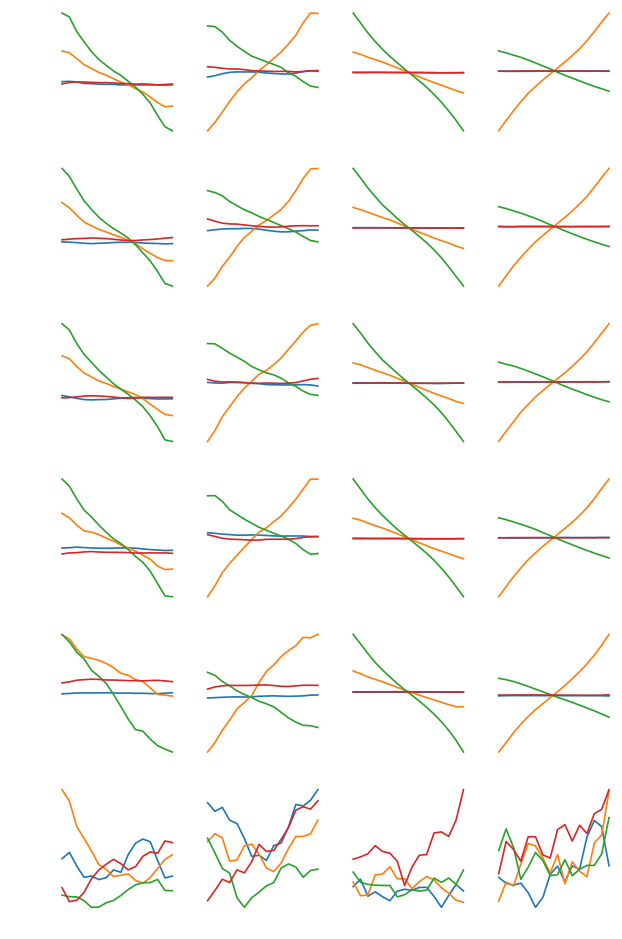

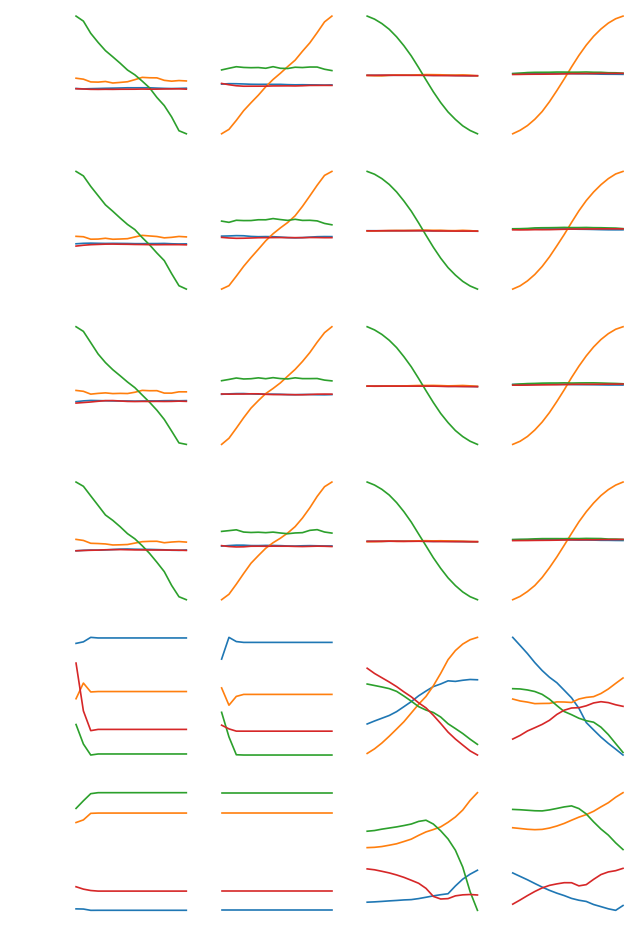

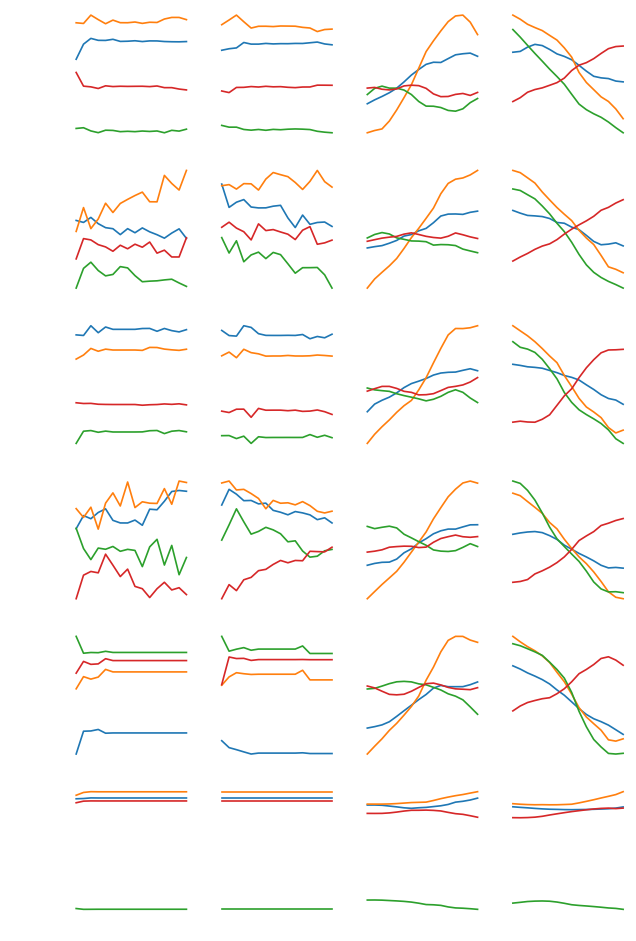

In [14]:
for bb,bet in enumerate(normalized_beta_values):
    samebeta = range(bb,nb*ng,nb)
    if any([isTrained[i] for i in range(bb,nb*ng,nb)]):
        _ = plotCircleSweep(yhat[samebeta,:,:,:], x_sweep,nb,nimgs=0)
        plt.savefig("pred_bVAE_latents_b%0.4f.pdf" % bet, dpi=300)

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


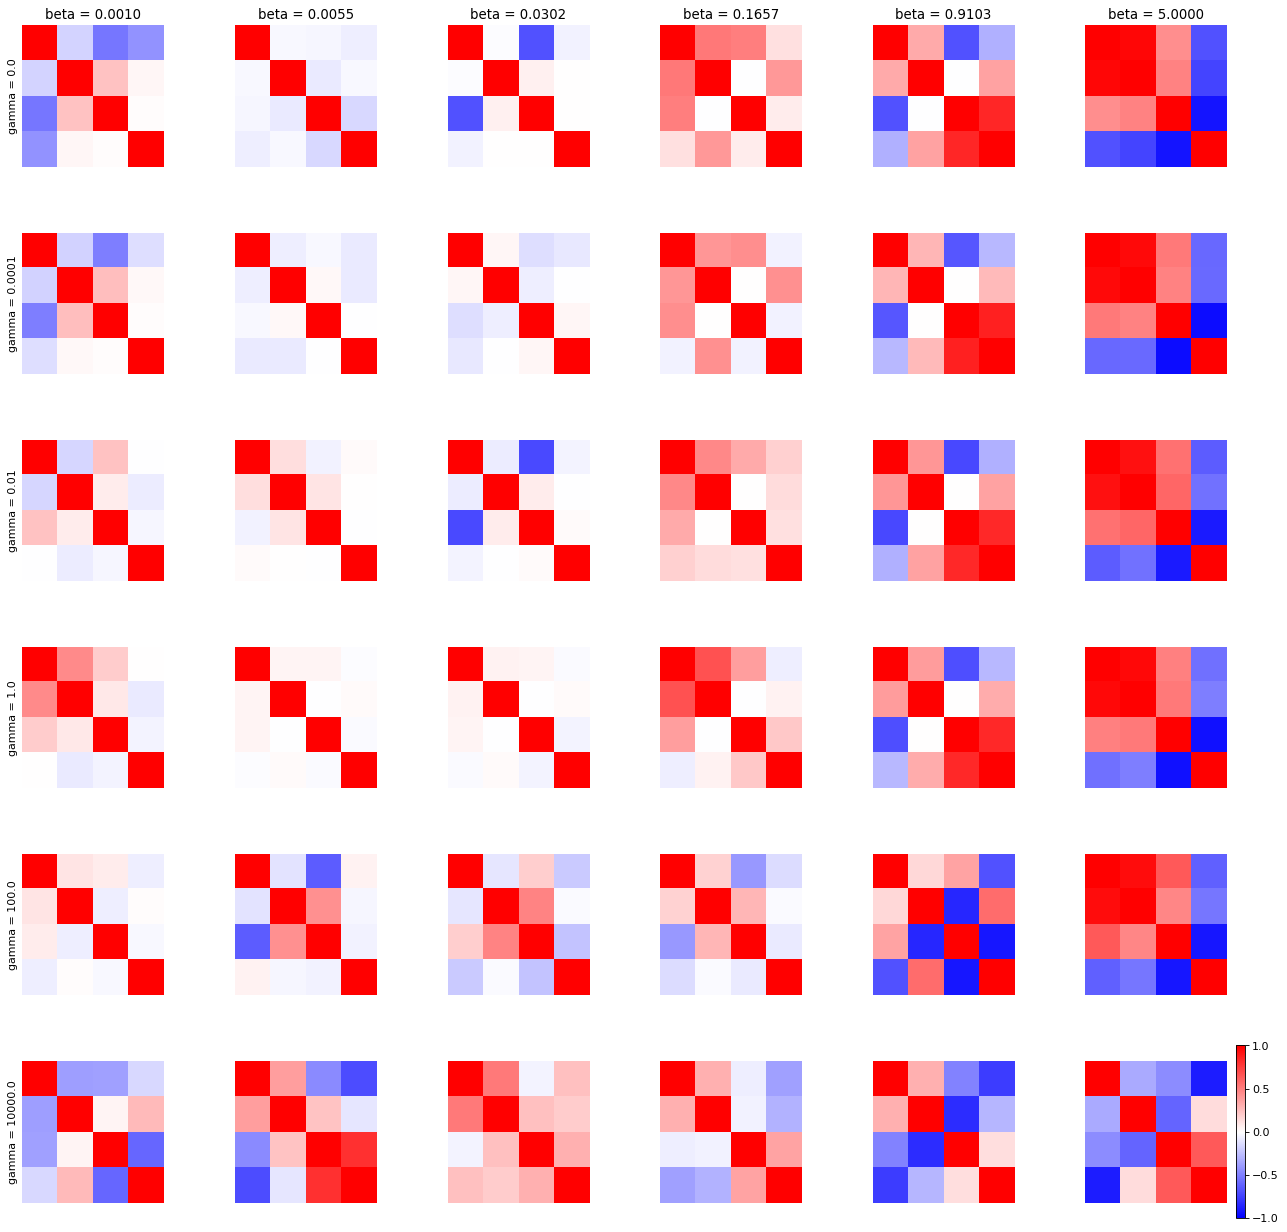

In [16]:
n_clusters=2

ng=6
nb=6
mss = np.ndarray(shape=(ng,nb),dtype=float)

fig, ax = plt.subplots(ng,nb,figsize=(20,20),
                       dpi= 80, facecolor='w', edgecolor='k')
for gg in range(ng):
    for jj in range(nb):
        if isTrained[(nb*gg+jj)]:
            plt.subplot(ng,nb,gg*nb+jj+1)

            corr_sup = np.corrcoef(yhat[nb*gg+jj,:,:,:].view(-1,n_latent).detach().numpy().T)
            
            if n_clusters<n_latent and n_clusters>1:
                model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
                model.fit(corr_sup)
                newcs = corr_sup[np.argsort(model.row_labels_)]
                newcs = newcs[:, np.argsort(model.column_labels_)]
                corr_sup = newcs
            
            # mean of squared off-diagonal elements
            mss[gg,jj] = np.mean((corr_sup-np.eye(n_latent))**2)

            # Plot covariance
            plt.set_cmap('bwr')
            plt.imshow(corr_sup, vmin=-1, vmax=1)
            cb = plt.colorbar()
            colorAxisNormalize(cb)
            ax[gg,jj] = plt.gca()
            ax[gg,jj].axes.get_xaxis().set_ticks([])
            ax[gg,jj].axes.get_yaxis().set_ticks([])
            plt.box(False)

            if jj is not nb-1 or gg is not ng-1:
                cb.remove()
        if gg==0:
            plt.title('beta = %0.4f' % normalized_beta_values[jj])
        if jj==0:
            plt.ylabel('gamma = %s' % gamma_values[gg])

Text(0.5, 1.0, 'mean squared cross-correlations')

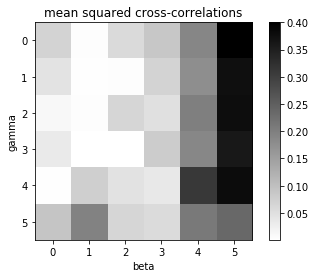

In [17]:
plt.imshow(mss)
plt.colorbar()
plt.set_cmap('gray_r')
plt.ylabel('gamma')
plt.xlabel('beta')
plt.title('mean squared cross-correlations')

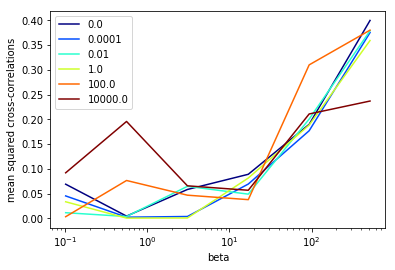

In [18]:
plt.gca().set_prop_cycle(color=col)
plt.plot(beta,mss.T)
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('mean squared cross-correlations')
plt.legend(gamma_values)

Our finding from our experiments on classic $\beta$-VAE holds: increasing entanglement with increasing $\beta$. At a glance, $\gamma$ near 1 appears to further disentangle at low $\beta$, but this might not be significant.

### Generate synthetic z's, decode/reconstruct them

In [19]:
mins,_ = yhat.permute(1,2,3,0).view(-1,n_latent,nb*ng).min(0)
maxs,_ = yhat.permute(1,2,3,0).view(-1,n_latent,nb*ng).max(0)
means = yhat.permute(1,2,3,0).view(-1,n_latent,nb*ng).mean(0)
mins,means,maxs,means.shape

(tensor([[-1.5324e+00, -1.6043e+00, -8.0595e-01, -7.4879e-03, -6.7421e-03,
          -2.2131e-04, -1.4762e+00, -1.3582e+00, -8.8512e-01, -8.5221e-03,
          -7.3178e-03, -1.7052e-04, -1.6226e+00, -1.3823e+00, -7.2854e-01,
          -9.1868e-03, -6.2506e-03, -3.9960e-04, -8.3142e-01, -1.0092e+00,
          -1.2263e+00, -9.1072e-03, -6.7928e-03, -4.9372e-04, -7.0606e-02,
          -1.4536e-01, -6.4579e-04, -6.3964e-03, -4.3732e-03, -5.1365e-04,
          -3.1261e-02, -9.8822e-03, -5.3361e-03, -1.7336e-03, -1.3517e-04,
           2.6610e-04],
         [-1.6461e+00, -1.9560e+00, -1.9499e+00, -1.6031e+00, -9.5159e-01,
          -9.7089e-04, -1.6246e+00, -1.8988e+00, -2.0102e+00, -1.6048e+00,
          -9.5011e-01, -1.0772e-03, -1.7349e+00, -1.6346e+00, -1.9955e+00,
          -1.6064e+00, -9.4741e-01, -1.0808e-03, -9.2732e-01, -1.1340e+00,
          -1.7625e+00, -1.5840e+00, -9.4614e-01, -1.1957e-03, -7.8357e-02,
          -1.3071e-01, -3.3343e-01, -7.1219e-01, -5.9162e-03, -9.1022e-04,
 

/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


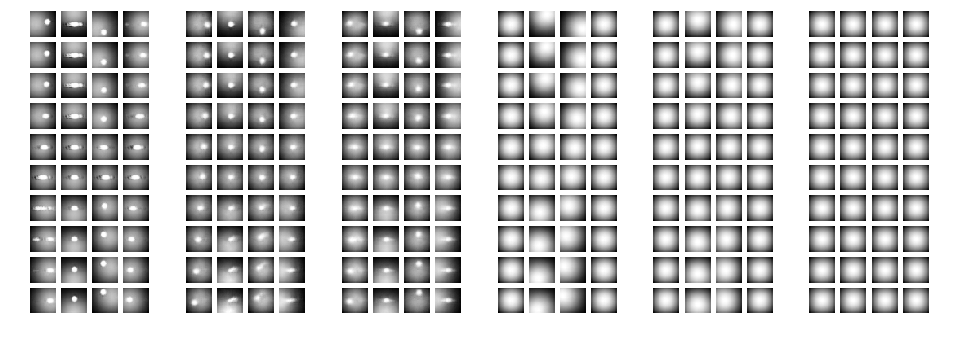

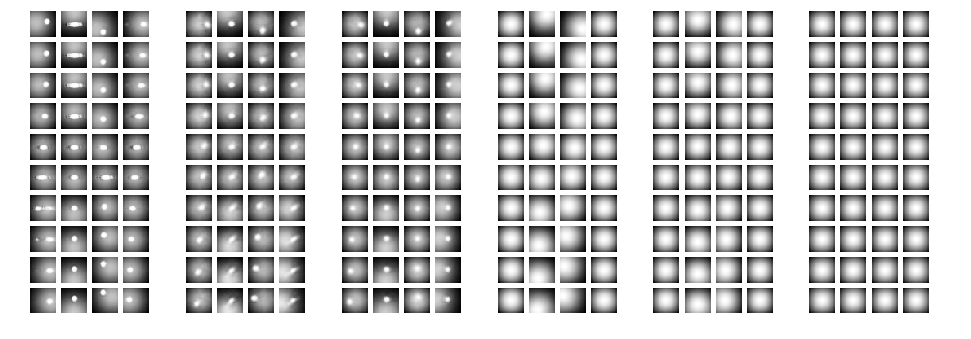

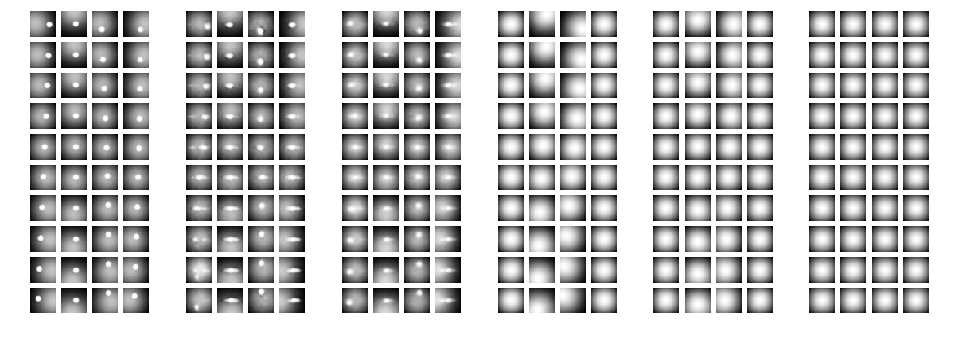

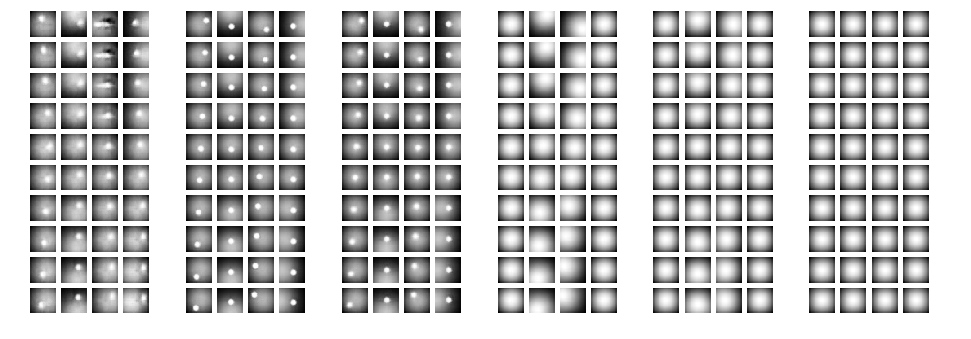

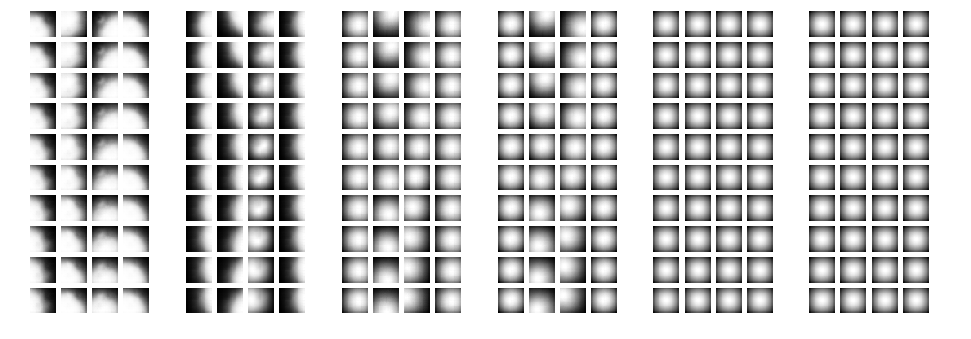

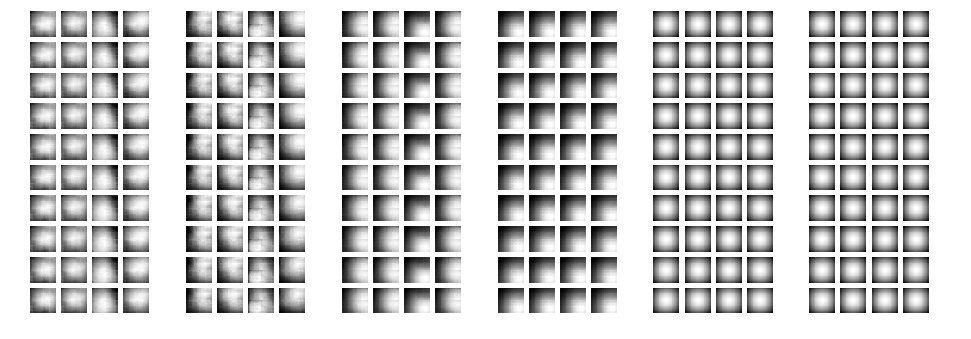

In [20]:
n_frames = 10
_, x_sweep = sweepCircleLatents(vae[nb*gg+jj],latents=np.linspace(0,1,n_frames))

recon_error = np.zeros_like(mss)

for gg in range(0,ng):
    # z.shape,recon.shape,z
    fig, ax = plt.subplots(n_frames,(n_latent+1)*nb,figsize=(15,5),
                           dpi= 80, facecolor='w', edgecolor='k')

    for jj in range(0,nb):

        for ll in range(0,n_latent):
            z = means[:,jj].repeat(n_frames,1).t()
            z[ll,:] = torch.linspace(mins[ll,nb*gg+jj].detach(),maxs[ll,nb*gg+jj].detach(),n_frames)
            recon = vae[nb*gg+jj].decode(z.t())
            recon_error[gg,jj] = ((x_sweep[ll,2:,:,:,:] - recon[:,2:,:,:,:])**2).mean()

            plt.set_cmap('gray')
            for ff in range(0,n_frames):
                plt.subplot(n_frames,(n_latent+1)*nb,((n_latent+1)*nb)*ff+(n_latent+1)*jj+ll+1)
                plt.imshow(recon[:,ff,:,:,:].detach().squeeze())
                plt.axis('off')
        for ff in range(0,n_frames):
            plt.subplot(n_frames,(n_latent+1)*nb,((n_latent+1)*nb)*ff+(n_latent+1)*jj+n_latent+1)
            plt.axis('off')

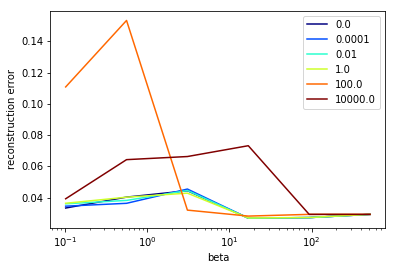

In [21]:
plt.gca().set_prop_cycle(color=col)
plt.plot(beta,recon_error.T)
plt.xscale('log')
plt.ylabel('reconstruction error')
plt.xlabel('beta')
plt.legend(gamma_values)